In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [3]:
df = df.rename(columns={'conversion': 'target',
                        'offer': 'treatment'})
df['treatment'].replace({'No Offer': 0, 
                         'Buy One Get One': 1,
                         'Discount': 1}, inplace = True)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [5]:
df = pd.get_dummies(df, prefix=['zip_code', 'channel'])
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,0,0,1,0,0,0,1
3,9,675.83,1,0,1,1,0,1,0,0,0,0,1
4,2,45.34,1,0,0,1,0,0,0,1,0,0,1


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

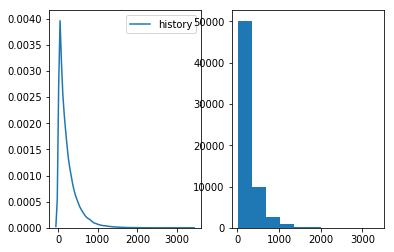

In [7]:
plt.subplot(1,2,1)
sns.kdeplot(df['history'])
plt.subplot(1,2,2)
plt.hist(df['history'])
plt.show()

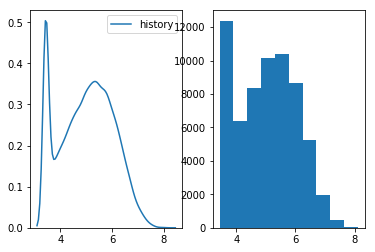

In [8]:
df['history'] = np.log(df['history'] + 1)

plt.subplot(1,2,1)
sns.kdeplot(df['history'])
plt.subplot(1,2,2)
plt.hist(df['history'])
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
def uplift_train_test_split(df, **params):
    train_index, test_index = train_test_split(df.index, **params)
    
    X_train = df.loc[train_index, :]
    X_test = df.loc[test_index, :]
    X_train = X_train.drop(['target', 'treatment'], axis=1)
    X_test = X_test.drop(['target', 'treatment'], axis=1)
    
    y_train = df.loc[train_index, 'target']
    y_test = df.loc[test_index, 'target']
    
    treat_train = df.loc[train_index, 'treatment']
    treat_test = df.loc[test_index, 'treatment']
    
    return X_train, X_test, y_train, y_test, treat_train, treat_test

In [11]:
X_train, X_test, y_train, y_test, treat_train, treat_test = uplift_train_test_split(df, test_size=0.3, random_state=42)

In [12]:
X_train.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
9656,7,6.076150,1,0,1,0,0,1,0,0,1
63037,1,5.933809,1,0,0,0,1,0,1,0,0
31405,3,4.951168,0,1,1,0,0,1,0,1,0
58088,3,5.022300,0,1,0,0,1,0,0,0,1
44344,2,4.233672,1,0,1,0,1,0,0,1,0


In [13]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds, plot_uplift_curve
from sklift.models import SoloModel

In [14]:
from catboost import CatBoostClassifier


score at 10: 0.11117494517182747
score at 20: 0.10410342820752677
score at 30: 0.10381702663681627



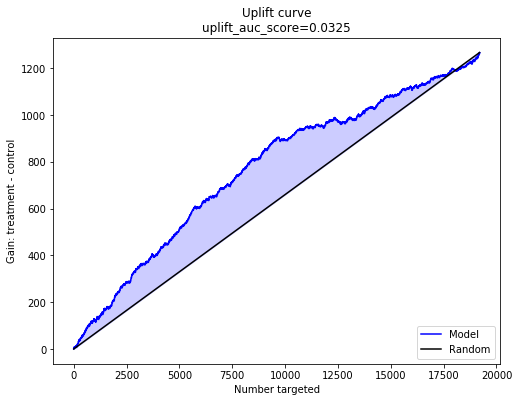

In [15]:
sm = SoloModel(CatBoostClassifier(iterations=100, learning_rate=0.025, thread_count=12, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_at_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_at_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score_at_30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)

print(f'''
score at 10: {sm_score_at_10}
score at 20: {sm_score_at_20}
score at 30: {sm_score_at_30}
''')

plot_uplift_curve(y_test, uplift_sm, treat_test, perfect=False)

In [16]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,23.515074
1,treatment,20.558756
2,used_bogo,13.069417
3,recency,11.157642
4,history,9.742721
5,used_discount,7.419235
6,zip_code_Rural,6.897859
7,channel_Web,5.024636
8,channel_Phone,1.187495
9,zip_code_Urban,0.634790


In [17]:
results = [['SoloModel', sm_score_at_10, sm_score_at_20, sm_score_at_30]]

In [18]:
from sklift.models import TwoModels


score at 10: 0.11354127786844656
score at 20: 0.09828879091011583
score at 30: 0.09964057140319582



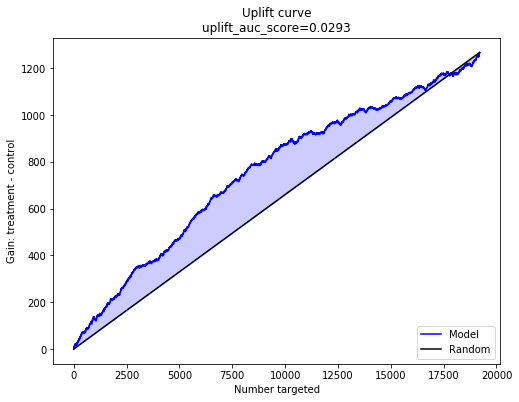

In [19]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=100, learning_rate=0.025, thread_count=12, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=100, learning_rate=0.025, thread_count=12, random_state=42, silent=True), 
    method='vanilla'
)

tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)

tm_score_at_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_at_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
tm_score_at_30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

print(f'''
score at 10: {tm_score_at_10}
score at 20: {tm_score_at_20}
score at 30: {tm_score_at_30}
''')

plot_uplift_curve(y_test, uplift_tm, treat_test, perfect=False)

In [20]:
results.append(['TwoModels', tm_score_at_10, tm_score_at_20, tm_score_at_30])

In [21]:
tm_fi = pd.DataFrame({
    'feature_name': tm.estimator_trmnt.feature_names_,
    'feature_score_treatment': tm.estimator_trmnt.feature_importances_,
    'feature_score_control': tm.estimator_ctrl.feature_importances_
}).sort_values('feature_score_treatment', ascending=False).reset_index(drop=True)

tm_fi

,feature_name,feature_score_treatment,feature_score_control
0,is_referral,25.560745,30.849017
1,used_bogo,19.232736,3.384969
2,recency,16.215058,19.422762
3,history,12.206526,16.084536
4,used_discount,10.722290,3.598604
5,channel_Web,6.371108,8.023977
6,zip_code_Rural,4.816213,12.348653
7,channel_Phone,2.191876,2.926477
8,zip_code_Urban,1.476616,1.695028
9,zip_code_Surburban,0.779996,1.228332


### Очень интересные веса признаков у разных моделей! У модели Treatment очень важными признаками являются признаки воздействия (used_bogo, used_discount), у модели Control важным стал признак региона (zip_code_Rural) ###

In [22]:
from sklift.models import ClassTransformation

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  



score at 10: 0.1074217463535301
score at 20: 0.09885584221287125
score at 30: 0.09904364482367581



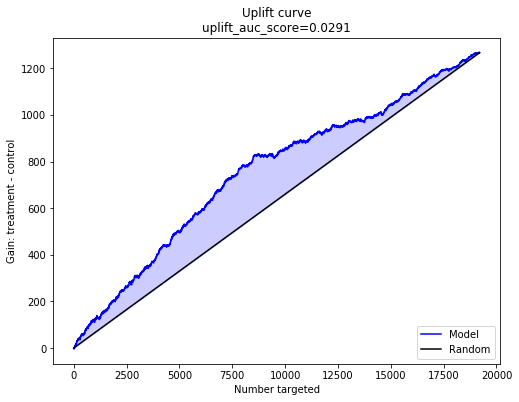

In [23]:
ct = ClassTransformation(CatBoostClassifier(iterations=100, learning_rate=0.025, thread_count=12, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_at_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_at_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
ct_score_at_30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

print(f'''
score at 10: {ct_score_at_10}
score at 20: {ct_score_at_20}
score at 30: {ct_score_at_30}
''')

plot_uplift_curve(y_test, uplift_ct, treat_test, perfect=False)

In [24]:
results.append(['ClassTransformation', ct_score_at_10, ct_score_at_20, ct_score_at_30])

In [25]:
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_fi

,feature_name,feature_score
0,history,22.568659
1,recency,20.762024
2,used_bogo,16.353790
3,is_referral,10.925437
4,channel_Web,8.624348
5,used_discount,7.364801
6,zip_code_Urban,3.844914
7,channel_Phone,2.785423
8,zip_code_Surburban,2.699040
9,zip_code_Rural,2.689418


In [26]:
results = pd.DataFrame(results, columns=['Uplift Name', 'Uplift at 10%', 'Uplift at 20%', 'Uplift at 30%'])
results

,Uplift Name,Uplift at 10%,Uplift at 20%,Uplift at 30%
0,SoloModel,0.111175,0.104103,0.103817
1,TwoModels,0.113541,0.098289,0.099641
2,ClassTransformation,0.107422,0.098856,0.099044


In [27]:
from IPython.display import Image
from causalml.inference.tree import UpliftRandomForestClassifier, UpliftTreeClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

ValueError: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 368 from C header, got 360 from PyObject

### как видно выше, мне так и не удалось победить библиотеку causalml. Про описание деревьев аплифта могу сказать следующее: смотрим на листья дерева, на их показатель аплифта и p_value, если изменения аплифта статистически значимы, по дереву можем проследить как мы попали в этот лист и сделать выводы об этой группе объектов. Так можем определить группы объектов к которым точно нужно применить воздействие для повышения конверсии, а так же можем определить группы объектов, к которым точно НЕ нужно применять воздействие, чтобы не потерять их. ###

In [28]:
uplift_sm

array([0.02990794, 0.04768692, 0.05866278, ..., 0.0492332 , 0.03219946,
       0.04867172])

In [29]:
df_sm = X_test.copy()
df_sm['target'] = y_test
df_sm['uplift'] = uplift_sm

df_sm.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,target,uplift
33042,9,4.187379,1,0,1,0,1,0,0,0,1,0,0.029908
7209,1,4.977561,0,1,0,0,0,1,0,0,1,0,0.047687
24367,1,6.600211,0,1,1,0,1,0,0,1,0,0,0.058663
19599,4,7.187098,1,0,1,0,1,0,1,0,0,1,0.044419
31465,2,5.569222,1,1,1,0,1,0,0,0,1,1,0.069473


In [30]:
df_sm.sort_values(by=['uplift'], ascending=False, inplace=True)
df_sm.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,target,uplift
28292,2,7.544364,1,1,1,0,1,0,0,0,1,0,0.075404
43077,2,7.245962,1,1,1,0,1,0,0,0,1,1,0.075404
47417,2,6.991103,1,1,1,0,1,0,0,0,1,0,0.075404
9881,2,7.191362,1,1,1,0,1,0,0,0,1,0,0.075404
25986,2,6.934417,1,1,1,0,1,0,0,0,1,1,0.075404


In [31]:
df_sm.tail()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,target,uplift
62477,4,5.568841,1,0,0,1,0,0,0,1,0,0,0.018239
23732,4,6.190541,1,0,0,1,0,0,0,1,0,1,0.018233
12428,4,5.982953,1,0,0,1,0,0,0,1,0,0,0.018032
48131,4,5.484963,1,0,0,1,0,0,0,1,0,1,0.017779
60221,4,6.184005,1,1,0,1,0,0,0,0,1,0,0.017599


In [32]:
df_sm['decile'] = pd.qcut(df_sm['uplift'], 10, labels=[*range(10, 0, -1)])
df_sm.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,target,uplift,decile
28292,2,7.544364,1,1,1,0,1,0,0,0,1,0,0.075404,1
43077,2,7.245962,1,1,1,0,1,0,0,0,1,1,0.075404,1
47417,2,6.991103,1,1,1,0,1,0,0,0,1,0,0.075404,1
9881,2,7.191362,1,1,1,0,1,0,0,0,1,0,0.075404,1
25986,2,6.934417,1,1,1,0,1,0,0,0,1,1,0.075404,1


In [33]:
df_sm.groupby('decile')['target'].mean().sort_values(ascending=False)

decile
1     0.210938
2     0.162669
3     0.160770
4     0.151641
7     0.150521
5     0.144716
8     0.130934
6     0.124479
9     0.117525
10    0.109896
Name: target, dtype: float64

### мы получили среднюю конверсию по каждому децилю, давайте посмотрим на среднюю в квартилях ###

In [34]:
df_sm['quartile'] = pd.qcut(df_sm['uplift'], 4, labels=[*range(4, 0, -1)])
df_sm.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,target,uplift,decile,quartile
28292,2,7.544364,1,1,1,0,1,0,0,0,1,0,0.075404,1,1
43077,2,7.245962,1,1,1,0,1,0,0,0,1,1,0.075404,1,1
47417,2,6.991103,1,1,1,0,1,0,0,0,1,0,0.075404,1,1
9881,2,7.191362,1,1,1,0,1,0,0,0,1,0,0.075404,1,1
25986,2,6.934417,1,1,1,0,1,0,0,0,1,1,0.075404,1,1


In [35]:
df_sm.groupby('quartile')['target'].mean().sort_values(ascending=False)

quartile
1    0.183542
2    0.148750
3    0.136070
4    0.117267
Name: target, dtype: float64